In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
import spacy
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [37]:
import time
from sklearn.model_selection import cross_val_score

class Model(object):
    
    def __init__(self,name,X,Y,modelObj,test=False,**modelParams):
        self.params = modelParams
        self.modelObj = modelObj.set_params(**self.params)  
        self.name = name
        self.X = X
        self.Y = Y
        self.initValues(test)   
    
    def initValues(self, test):
        start = time.time()
        self.modObjFit = self.modelObj.fit(self.X, self.Y)
        end = time.time()
        self.timeToRun = end - start
        self.cvTrain = cross_val_score(self.modelObj, self.X, self.Y, cv=5)
        self.cvTrainMean = np.mean(self.cvTrain)
        self.cvTrainRange = max(self.cvTrain) - min(self.cvTrain)
    
    def performance(self, boxPlot=True):
        print ("Model:\t\t" + str(self.name))
        print ("CV Mean:\t" + str(self.cvTrainMean))
        print ("CV Range:\t" + str(self.cvTrainRange))
        print ("Train Time:\t" + str(self.timeToRun))
        print ("CV Scores: ")
        print (self.cvTrain)
        if boxPlot:
            fig = plt.figure()
            title = "Performance: %s" % (self.name)
            fig.suptitle(title)
            ax = fig.add_subplot(111)
            plt.boxplot(self.cvTrain, showmeans=True)
            ax.set_xticklabels(self.name)
            plt.show()      
    
    def compareBox(self,modelList,filterResult=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.cvTrain)
        names.append(self.name)
        
        for rightModel in modelList:
            if filterResult > 0:
                if rightModel.cvTrain.mean() > filterResult:
                    results.append(rightModel.cvTrain)
                    names.append(rightModel.name)
            else:
                results.append(rightModel.cvTrain)
                names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results, showmeans=True)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels,folds=False):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        cvNameList= []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToRun,
                                'CV Mean':model.cvTrainMean,
                                'CV Range': model.cvTrainRange}
            if folds:  
                buildCvNameList = False
                if not cvNameList:
                    buildCvNameList=True
                for idx,cv in enumerate(model.cvTrain):
                    cvName = 'CV Fold ' + str(idx+1)
                    if buildCvNameList:
                        cvNameList.append(cvName)
                    dataRowForFrame[cvName] = cv
            dataForFrame.append(dataRowForFrame)
        colOrder = ['Name', 'CV Mean', 'CV Range', 'Time']
        colOrder += cvNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels)

In [3]:
import nltk
# Launch the installer to download "gutenberg" and "stop words" corpora.
#nltk.download()

In [4]:
# Import the data we just downloaded and installed.
from nltk.corpus import gutenberg, stopwords

# Grab and process the raw data.
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [40]:
def prepGutenTextRaw (title):
    
    book = gutenberg.raw(title)
    
    # Remove Title
    pattern = "[\[].*?[\]]"
    book_noTitle = re.sub(pattern, "", book[0:999999])
    
    # recognize: the double dash '--'
    book_noTitle = re.sub(r'--',' ',book_noTitle)
    book_noTitle = re.sub("[\[].*?[\]]", "", book_noTitle)
    book_noTitle = ' '.join(book_noTitle.split())
    
    # Now we'll match and remove chapter headings and make lower
    book_noChaps = re.sub(r'chapter *.', '', book_noTitle.lower())

    nlp = spacy.load('en')
    book_doc = nlp(book_noChaps)
    
    # Let's explore the objects we've built.
    print("The {} object is a {} object.".format(title, type(book_doc)))
    print("It is {} tokens long".format(len(book_doc)))
    print("The first three tokens are '{}'".format(book_doc[:3]))
    print("The type of each token is {}".format(type(book_doc[0])))
    
    
    #from nltk.stem.wordnet import WordNetLemmatizer
    #lmtzr = WordNetLemmatizer()
    #book_doc = [ lmtzr.lemmatize(token.text) for token in book_doc]
    #remove stop words
    
    book_sents = [[sent, title.split('-', 2)[0]] for sent in book_doc.sents]

    return book_doc,book_sents
    

In [41]:
moby_doc,moby_sents = prepGutenTextRaw('melville-moby_dick.txt')

The melville-moby_dick.txt object is a <class 'spacy.tokens.doc.Doc'> object.
It is 206753 tokens long
The first three tokens are 'etymology. ('
The type of each token is <class 'spacy.tokens.token.Token'>


In [42]:
leaves_doc, leaves_sents = prepGutenTextRaw('whitman-leaves.txt')

The whitman-leaves.txt object is a <class 'spacy.tokens.doc.Doc'> object.
It is 150253 tokens long
The first three tokens are 'come, said'
The type of each token is <class 'spacy.tokens.token.Token'>


# BOW

In [43]:
sentences = pd.DataFrame(moby_sents + leaves_sents)
sentences.head()

,0,1
0,"(etymology, .)",melville
1,"((, supplied, by, a, late, consumptive, usher,...",melville
2,"(he, was, ever, dusting, his, old, lexicons, a...",melville
3,"(he, loved, to, dust, his, old, grammars, ;, i...",melville
4,"(while, you, take, in, hand, to, school, other...",melville


In [44]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
mobywords = bag_of_words(moby_doc)
leaveswords = bag_of_words(leaves_doc)

# Combine bags to create a set of unique words.
common_words = set(mobywords + leaveswords)

In [45]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500
Processing row 11000
Processing row 11500
Processing row 12000


,hardly,purse,orange,wine,canaller,sane,translate,seed,conceal'd,passionately,...,write,mountain,murk,log,rude,recitative,track,game,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(etymology, .)",melville
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"((, supplied, by, a, late, consumptive, usher,...",melville
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(he, was, ever, dusting, his, old, lexicons, a...",melville
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(he, loved, to, dust, his, old, grammars, ;, i...",melville
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(while, you, take, in, hand, to, school, other...",melville


# Logistic Regression

In [46]:
X = word_counts.drop(['text_source', 'text_sentence'], 1)
y = word_counts['text_source']


In [47]:
X.head()

,hardly,purse,orange,wine,canaller,sane,translate,seed,conceal'd,passionately,...,pike,wrinkle,write,mountain,murk,log,rude,recitative,track,game
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model:		BOW Vanilla Reg
CV Mean:	0.793001235076
CV Range:	0.120625771923
Train Time:	4.201193809509277
CV Scores: 
[ 0.7254014   0.80156443  0.79991766  0.84602717  0.79209551]


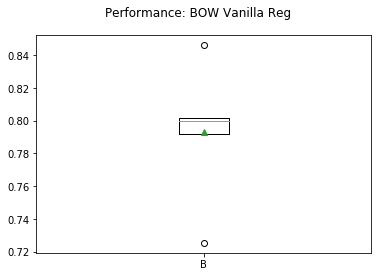

In [48]:
# Vanilla 
bowVanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
bowVanRegModel = Model('BOW Vanilla Reg',X,y,LogisticRegression(),**bowVanRegModelParams)
bowVanRegModel.performance()

# tf-idf

In [153]:
#create tf-idf tool
tfIdfV = TfidfVectorizer(ngram_range=(1, 2), 
                           max_features=5000,
                           analyzer='word', 
                           lowercase=True)

In [154]:
sentences.head()

,0,1
0,"(etymology, .)",melville
1,"((, supplied, by, a, late, consumptive, usher,...",melville
2,"(he, was, ever, dusting, his, old, lexicons, a...",melville
3,"(he, loved, to, dust, his, old, grammars, ;, i...",melville
4,"(while, you, take, in, hand, to, school, other...",melville


In [155]:
tfIdfFeats = tfIdfV.fit_transform(sentences[0].astype(str))

In [156]:
y = sentences[1]

# BOW and tf-idf Logistic Regression Comparison

Model:		tfidf Vanilla Reg
CV Mean:	0.789954713874
CV Range:	0.0687525730753
Train Time:	0.7708618640899658
CV Scores: 
[ 0.75092631  0.81762042  0.76533553  0.81967888  0.79621243]


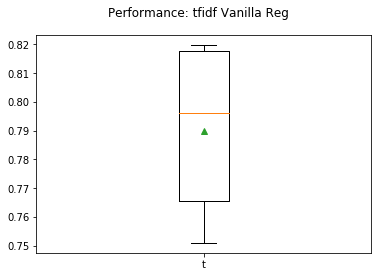

In [157]:
# Vanilla 
tfidfVanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
tfidfVanRegModel = Model('tfidf Vanilla Reg',tfIdfFeats,y,LogisticRegression(),**tfidfVanRegModelParams)
tfidfVanRegModel.performance()

,Name,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,tfidf Vanilla Reg,0.789955,0.068753,0.770862,0.750926,0.817620,0.765336,0.819679,0.796212
1,BOW Vanilla Reg,0.793001,0.120626,4.201194,0.725401,0.801564,0.799918,0.846027,0.792096


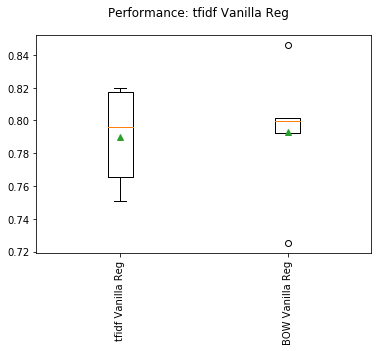

In [158]:
tfidfVanRegModel.fullCompareList([bowVanRegModel], folds=True)

# Increase Percentage Points

## More Cleaning

In [159]:
from nltk.stem.wordnet import WordNetLemmatizer

def prepGutenTextRawCleaner (title):
    
    book = gutenberg.raw(title)
    
    # Remove Title
    pattern = "[\[].*?[\]]"
    book_noTitle = re.sub(pattern, "", book[0:999999])
    
    # recognize: the double dash '--'
    book_noTitle = re.sub(r'--',' ',book_noTitle)
    book_noTitle = re.sub("[\[].*?[\]]", "", book_noTitle)
    book_noTitle = ' '.join(book_noTitle.split())
    
    # Now we'll match and remove chapter headings and make lower
    book_noChaps = re.sub(r'chapter *.', '', book_noTitle.lower())

    nlp = spacy.load('en')
    book_doc = nlp(book_noChaps)
    
    # Let's explore the objects we've built.
    print("The {} object is a {} object.".format(title, type(book_doc)))
    print("It is {} tokens long".format(len(book_doc)))
    print("The first three tokens are '{}'".format(book_doc[:3]))
    print("The type of each token is {}".format(type(book_doc[0])))
    
    from nltk.stem.wordnet import WordNetLemmatizer
    lmtzr = WordNetLemmatizer()
    
    #remove stop words
    book_sents=[[]]
    author=title.split('-', 2)[0]
    
    for sent in book_doc.sents:
        # use lemmas
        sent_lmtz = lmtzr.lemmatize(sent.text)
        
        
        book_sents.append([sent_lmtz, author])
    

    return book_doc,book_sents
    

In [160]:
moby_doc_clnr,moby_sents_clnr = prepGutenTextRawCleaner('melville-moby_dick.txt')

The melville-moby_dick.txt object is a <class 'spacy.tokens.doc.Doc'> object.
It is 206753 tokens long
The first three tokens are 'etymology. ('
The type of each token is <class 'spacy.tokens.token.Token'>


In [161]:
leaves_doc_clnr,leaves_sents_clnr = prepGutenTextRawCleaner('whitman-leaves.txt')

The whitman-leaves.txt object is a <class 'spacy.tokens.doc.Doc'> object.
It is 150253 tokens long
The first three tokens are 'come, said'
The type of each token is <class 'spacy.tokens.token.Token'>


In [162]:
sentences_clnr = pd.DataFrame(moby_sents_clnr + leaves_sents_clnr)
sentences_clnr = sentences_clnr.dropna()

## Retry Vanilla Regression

In [140]:
tfIdfFeats_clnr = tfIdfV.fit_transform(sentences_clnr[0].astype(str))
y_clnr = sentences_clnr[1]

Model:		Cleaner tfidf VReg
CV Mean:	0.824372169617
CV Range:	0.0666941128036
Train Time:	0.7689990997314453
CV Scores: 
[ 0.79621243  0.84396871  0.80650473  0.86290655  0.81226842]


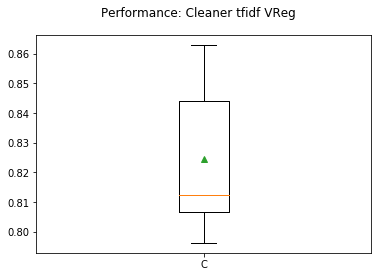

In [166]:
# Vanilla 
tfidfClnVanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
tfidfClnVanRegModel = Model('Cleaner tfidf VReg',tfIdfFeats_clnr,y_clnr,LogisticRegression(),**tfidfVanRegModelParams)
tfidfClnVanRegModel.performance()

## Change Vectorizer Params

In [163]:
tfIdfV2 = TfidfVectorizer(max_df=0.25, # drop words that occur in more than half the paragraphs
                             min_df=4, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [164]:
tfIdf2Feats_clnr = tfIdfV2.fit_transform(sentences_clnr[0].astype(str))
y_clnr = sentences_clnr[1]

Model:		New tfidf Params VReg
CV Mean:	0.794895018526
CV Range:	0.0794565664883
Train Time:	0.9672513008117676
CV Scores: 
[ 0.75257308  0.81062166  0.77480445  0.83202964  0.80444627]


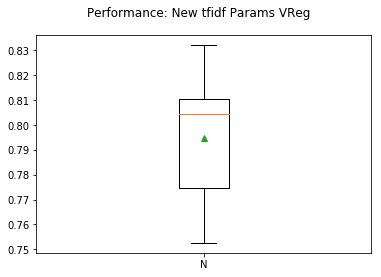

In [176]:
# Vanilla 
tfidf2VanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
tfidf2VanRegModel = Model('New tfidf Params VReg',tfIdf2Feats_clnr,y_clnr,LogisticRegression(),**tfidfVanRegModelParams)
tfidf2VanRegModel.performance()

# LSA

In [173]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
Xlsa = lsa.fit_transform(tfIdfFeats_clnr)

Model:		LSA VReg
CV Mean:	0.84265129683
CV Range:	0.053931659119
Train Time:	0.6873688697814941
CV Scores: 
[ 0.81762042  0.86249485  0.81226842  0.86620008  0.8546727 ]


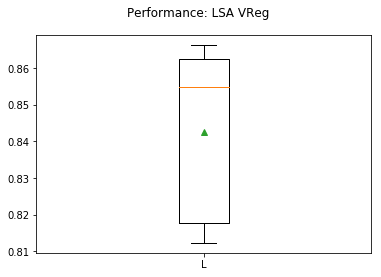

In [175]:
# Vanilla 
lsaVanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
lsaVanRegModel = Model('LSA VReg',Xlsa,y_clnr,LogisticRegression(),**tfidfVanRegModelParams)
lsaVanRegModel.performance()

# Final Comparison

,Name,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,New tfidf Params VReg,0.794895,0.079457,0.967251,0.752573,0.810622,0.774804,0.832030,0.804446
1,Cleaner tfidf VReg,0.824372,0.066694,0.768999,0.796212,0.843969,0.806505,0.862907,0.812268
2,tfidf Vanilla Reg,0.789955,0.068753,0.770862,0.750926,0.817620,0.765336,0.819679,0.796212
3,LSA VReg,0.842651,0.053932,0.687369,0.817620,0.862495,0.812268,0.866200,0.854673


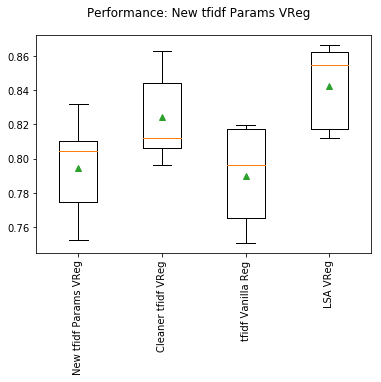

In [178]:
tfidf2VanRegModel.fullCompareList([tfidfClnVanRegModel,tfidfVanRegModel,lsaVanRegModel], folds=True)

# Conclusion

Lemmatizing the input helped increase the accuracy by about 3%.  Using LSA increased the accuracy by about 5%.